# Load Module

In [123]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from sklearn.model_selection import train_test_split

# function to compare Manual calculate gradient with autograd gradient

In [124]:
def cmp(s,dt,t):
  ex=torch.all(dt==t.grad).item()
  app=torch.allclose(dt,t.grad)
  maxdiff=(dt-t.grad).abs().max().item()
  print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

# Download Dataset

In [125]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Preprocess Data

In [126]:
x_train=torch.cat([i[0] for i in train_data if i[1]==8 or i[1]==9],dim=0)
y_train=torch.tensor([i[1] for i in train_data if i[1]==8 or i[1]==9]).unsqueeze(1)
x_test=torch.cat([i[0] for i in test_data if i[1]==8 or i[1]==9],dim=0)
y_test=torch.tensor([i[1] for i in test_data if i[1]==8 or i[1]==9]).unsqueeze(1)

In [127]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

(torch.Size([11800, 28, 28]),
 torch.Size([11800, 1]),
 torch.Size([1983, 28, 28]),
 torch.Size([1983, 1]))

(<matplotlib.image.AxesImage at 0x7b9ef66c6b90>, tensor([9]))

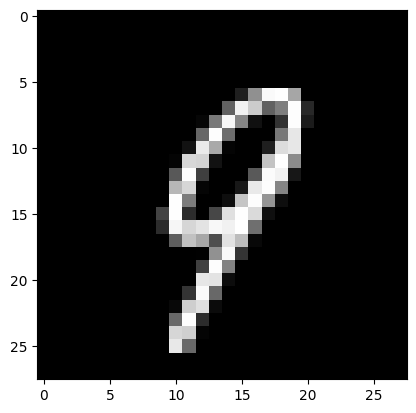

In [128]:
plt.imshow(x_train[3],cmap="gray"),y_train[3]

In [129]:
x_train=torch.flatten(x_train,1,2)
x_test=torch.flatten(x_test,1,2)

In [130]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

(torch.Size([11800, 784]),
 torch.Size([11800, 1]),
 torch.Size([1983, 784]),
 torch.Size([1983, 1]))

In [131]:
y_train=torch.tensor([1 if i.item()==9 else 0 for i in y_train]).unsqueeze(1)
y_test=torch.tensor([1 if i.item()==9 else 0 for i in y_test]).unsqueeze(1)

In [132]:
y_train.shape,y_test.shape

(torch.Size([11800, 1]), torch.Size([1983, 1]))

In [133]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [134]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

(torch.Size([9440, 784]),
 torch.Size([9440, 1]),
 torch.Size([2360, 784]),
 torch.Size([2360, 1]))

# Train and Validation

In [147]:
weight=torch.randn(x_train.shape[1],1)*0.01
weight.requires_grad_(True)
bias=torch.randn(1,1,requires_grad=True)
alpha=0.01

In [148]:
weight.grad,bias.grad

(None, None)

In [149]:
weight.shape,bias.shape

(torch.Size([784, 1]), torch.Size([1, 1]))

In [150]:
def sigmoid(z):
  return 1/(1+torch.exp(-z))

In [151]:
z=x_train@weight+bias
sig=sigmoid(z)
loss=(-y_train*torch.log(sig)-(1-y_train)*torch.log(1-sig)).mean()
loss.backward()
dl_dsig=-(y_train-sig)/(sig*(1-sig))
dl_dz=dl_dsig*(sig*(1-sig))
dl_dw=(x_train.T@dl_dz)/x_train.shape[0]
dl_db=dl_dz.mean()

In [152]:
cmp("dl_dw",dl_dw,weight)
cmp("dl_db",dl_db,bias)

dl_dw           | exact: False | approximate: True  | maxdiff: 7.748603820800781e-07
dl_db           | exact: True  | approximate: True  | maxdiff: 0.0


In [153]:
weight=torch.randn(x_train.shape[1],1)*0.01
weight.requires_grad_(False)
bias=torch.randn(1,1,requires_grad=False)
alpha=0.01

In [154]:
train_loss=[]
val_loss=[]
for i in range(1000):
  z=x_train@weight+bias
  sig=sigmoid(z)
  loss=(-y_train*torch.log(sig)-(1-y_train)*torch.log(1-sig)).mean()
  train_loss.append(loss.item())
  dl_dsig=-(y_train-sig)/(sig*(1-sig))
  dl_dz=dl_dsig*(sig*(1-sig))
  dl_dw=(x_train.T@dl_dz)/x_train.shape[0]
  dl_db=dl_dz.mean()

  weight-=alpha*dl_dw
  bias-=alpha*dl_db

  # Validation
  z=x_val@weight+bias
  sig=sigmoid(z)
  loss=(-y_val*torch.log(sig)-(1-y_val)*torch.log(1-sig)).mean()
  val_loss.append(loss.item())

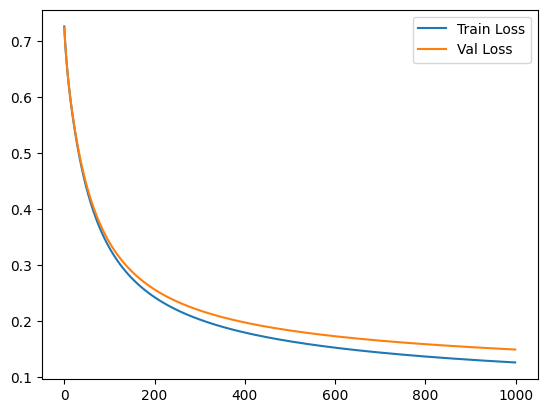

In [155]:
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label="Val Loss")
plt.legend()
plt.show()

# Test

In [156]:
z=x_test@weight+bias
sig=sigmoid(z)
sig=torch.tensor([1 if i.item()>0.5 else 0 for i in sig]).unsqueeze(1)
result=(sig==y_test).sum()/y_test.shape[0]
print(result.item())

0.9631870985031128


# Inference

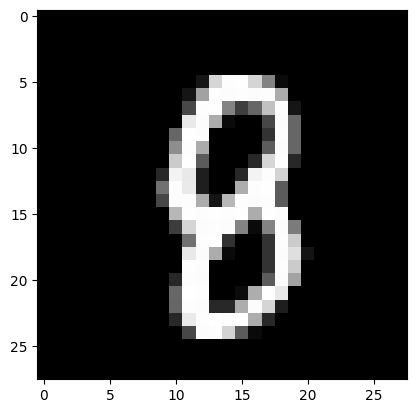

In [157]:
plt.imshow(x_test[25].view(-1,28),cmap="gray")

In [158]:
z=x_test[25].unsqueeze(0)@weight+bias
sig=sigmoid(z)
if sig.item()>0.5:
  print("9")
else:
  print("8")

8
